In [1]:
# Torch, Sklearn imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
## AllenNLP
import allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from allennlp.modules.token_embedders import BertEmbedder

print("PyTorch: {}".format(torch.__version__))
print("AllenNLP: {}".format(allennlp.__version__))

PyTorch: 1.0.0
AllenNLP: 0.8.0


In [3]:
## NLP libs
from nltk import download
import gensim
from nltk.corpus import stopwords
download('stopwords')

## General libs
import numpy as np
import pandas as pd
from string import punctuation
import os, re, sys, json, requests, pickle

02/05/2019 11:30:25 - INFO - summarizer.preprocessing.cleaner -   'pattern' package not found; tag filters are not available for English


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rsilvei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
elmo_weights_key_path = '../../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'
elmo_config_key_path = '../../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'

### Elmo Instance
elmo = Elmo(elmo_config_key_path, elmo_weights_key_path, num_output_representations = 1, dropout=0.3,requires_grad = False)

02/05/2019 11:30:27 - INFO - allennlp.modules.elmo -   Initializing ELMo


## Processing Dataset

In [5]:
def transformText(text, do_stop=False, do_stem=False):
    stops = set(stopwords.words("english"))
    # Convert text to lower
    text = text.lower()
    
    # Cleaning input
    text = text.replace("'s","")
    text = text.replace("’s","")
    text = text.replace("?","")
    text = text.replace("-","")
    text = text.replace('"',"")
    
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    # Removing all the stopwords
    if (do_stop==True):
        filtered_words = [word for word in text.split() if word not in stops]
    else:
        filtered_words = [word for word in text.split()]
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    if (do_stem==True):
        # Stemming
        text = gensim.parsing.preprocessing.stem_text(text)
    return text

## Lemmatization function based on Spacy Library
def lemmatizer_spacy(text):        
    sent = []
    doc = spacy_en(text)
    for word in doc:
        if word.lemma_ == "-PRON-":
            sent.append(word.text)
        else:
            sent.append(word.lemma_)
    return " ".join(sent)

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [6]:
dataset = pd.read_csv('intents.csv', sep=';')
dataset.rename(index=str, columns={"Intent": "intent", 
                                   "result": "phrases"},inplace=True)
dataset['clean_text']=dataset['phrases'].apply(lambda x: transformText(x))

## Augment dataset w/ more training phrases
dataset = pd.concat([dataset, dataset]).reset_index(drop=True)
## Suffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [7]:
def get_elmo(sent):
    elmo.eval()
    sent = [sent.split()]
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    rep = rep.squeeze(dim=0)
    avg = rep.mean(dim=0)
    return avg

### Introduce Augmentation in the Training Set

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import normal

In [9]:
## Plot phrases for given dataset
n_phrase_samples = 8
list_intents = {}
available_intents = ["promote", 
                     "demote",
                     #"jobOffer.create", 
                     #"jobReferral.evaluate",
                     #"personMaritalStatus.update",
                     #"personGender.update"
                    ]
for name in available_intents:
    phrases = list(dataset.clean_text[dataset.intent == name][0:n_phrase_samples])
    print(phrases)
    list_intents.update({name:phrases})

['give a merit to dan', 'promotion to this worker', 'upgrade this worker', 'upgrade this worker', 'provide merit to worker', 'provide merit to worker', 'promote worker to another unit', 'give a merit to dan']
['demote employee', 'downgrade employee', 'demote employee', 'downgrade associate', 'lower employee rank', 'downgrade employee', 'downgrade employee rank', 'demote worker']


In [10]:
sentences = [item for sublist in list(list_intents.values()) for item in sublist]
embeddings_np = np.zeros((len(sentences), elmo.get_output_dim()))
for i,sent in enumerate(sentences):
    embeddings_np[i]= get_elmo(sent).detach().numpy()

In [11]:
## Plot embeddings in low dim space
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 16 / 16
[t-SNE] Mean sigma: 2.020555
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.479837
[t-SNE] Error after 1000 iterations: 0.050896
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 16 / 16
[t-SNE] Mean sigma: 2.020555
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.825456
[t-SNE] Error after 1000 iterations: 0.046092


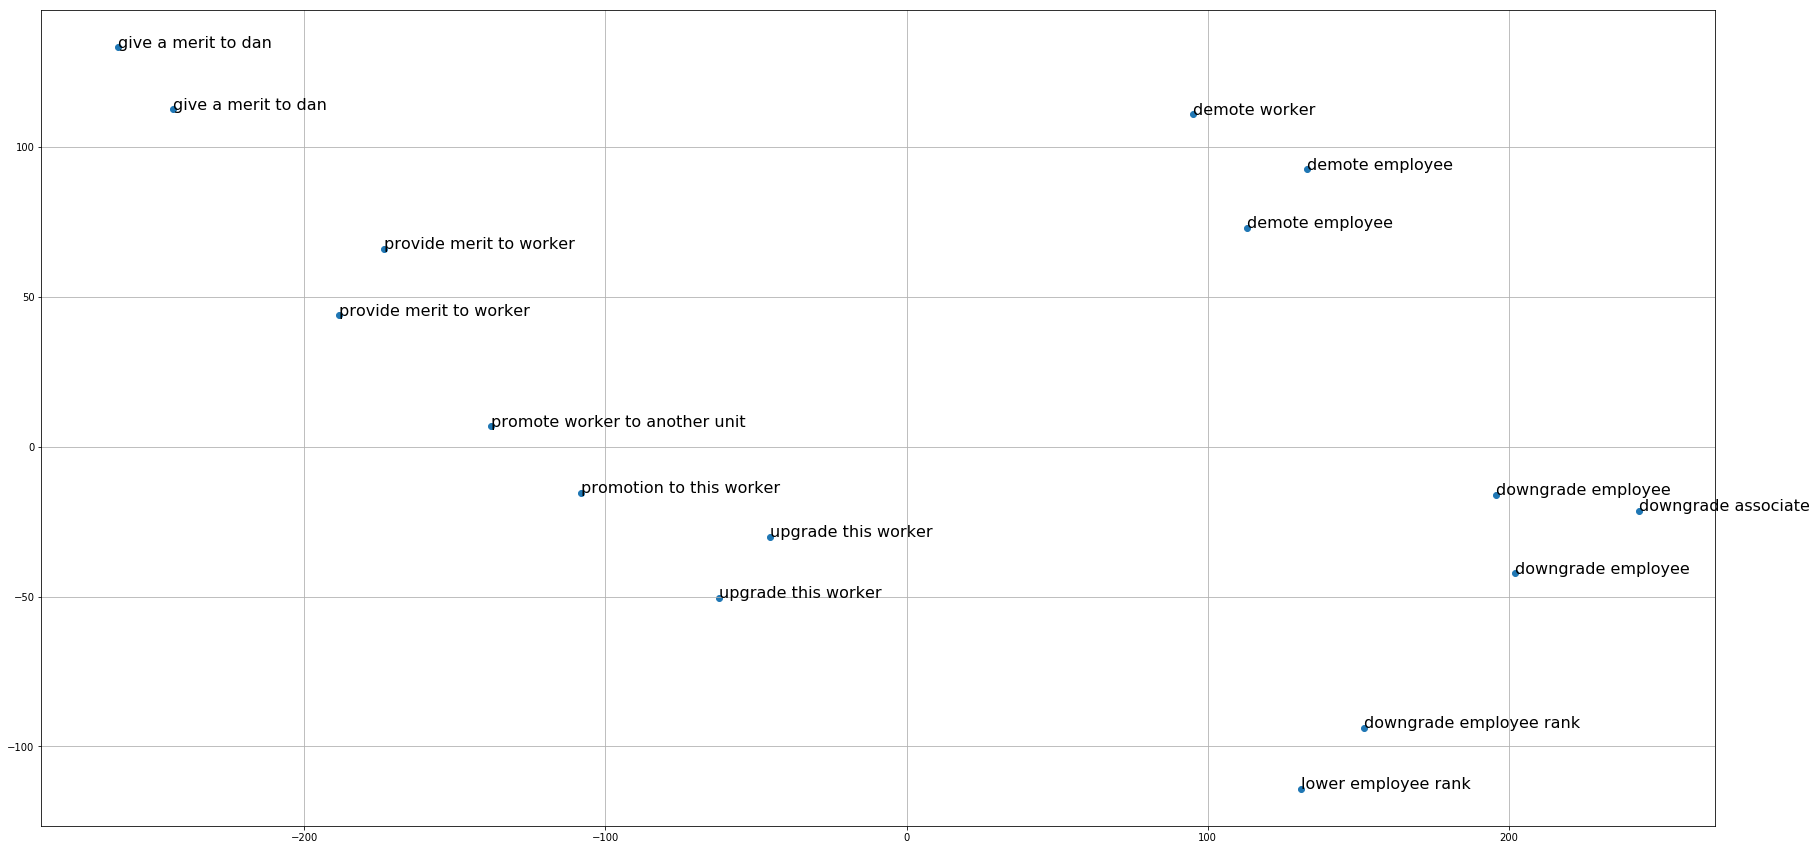

In [12]:
tsne=TSNE(n_components=2,perplexity =3, method ='exact',verbose=1)
sentences_tsne = tsne.fit_transform(embeddings_np)
tsne=TSNE(n_components=2,perplexity = 3, method ='exact',verbose=1)
sentences_tsne = tsne.fit_transform(embeddings_np)
plt.subplots(figsize=(30, 15))
plt.grid()
plt.scatter(sentences_tsne[:,0], sentences_tsne[:,1])
for label, x, y in zip(sentences,sentences_tsne[:,0], sentences_tsne[:,1]):
    font = {'size' : 16, 'weight' : 'normal'}
    plt.rc('font', **font)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

## 1 - Linear Interpolation

In [13]:
from torch.nn.functional import interpolate

In [14]:
syntetic_intent = "demote"
syntetic_label = "---interpolated_{}---".format(syntetic_intent)
phrases= list_intents[syntetic_intent]
points = np.zeros((1024,len(phrases)))
for i,utt in enumerate(phrases):
    points[:,i] = get_elmo(utt).detach().numpy()
point = torch.tensor(points)
x = point.unsqueeze(dim=0)

In [15]:
n_syntetic_samples = 20
interp = interpolate(x, size=(n_syntetic_samples), mode='linear').squeeze(0).numpy().T
embeddings_np = np.vstack((embeddings_np,interp))

/Users/rsilvei/Envs/nlp_new/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [16]:
## initial sizes
initial_sent_size = len(sentences)
for i in range(n_syntetic_samples):
    sentences.append(syntetic_label)
sentences

['give a merit to dan',
 'promotion to this worker',
 'upgrade this worker',
 'upgrade this worker',
 'provide merit to worker',
 'provide merit to worker',
 'promote worker to another unit',
 'give a merit to dan',
 'demote employee',
 'downgrade employee',
 'demote employee',
 'downgrade associate',
 'lower employee rank',
 'downgrade employee',
 'downgrade employee rank',
 'demote worker',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---',
 '---interpolated_demote---']

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 36 / 36
[t-SNE] Mean sigma: 1.428883
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.399395
[t-SNE] Error after 1000 iterations: 0.196363


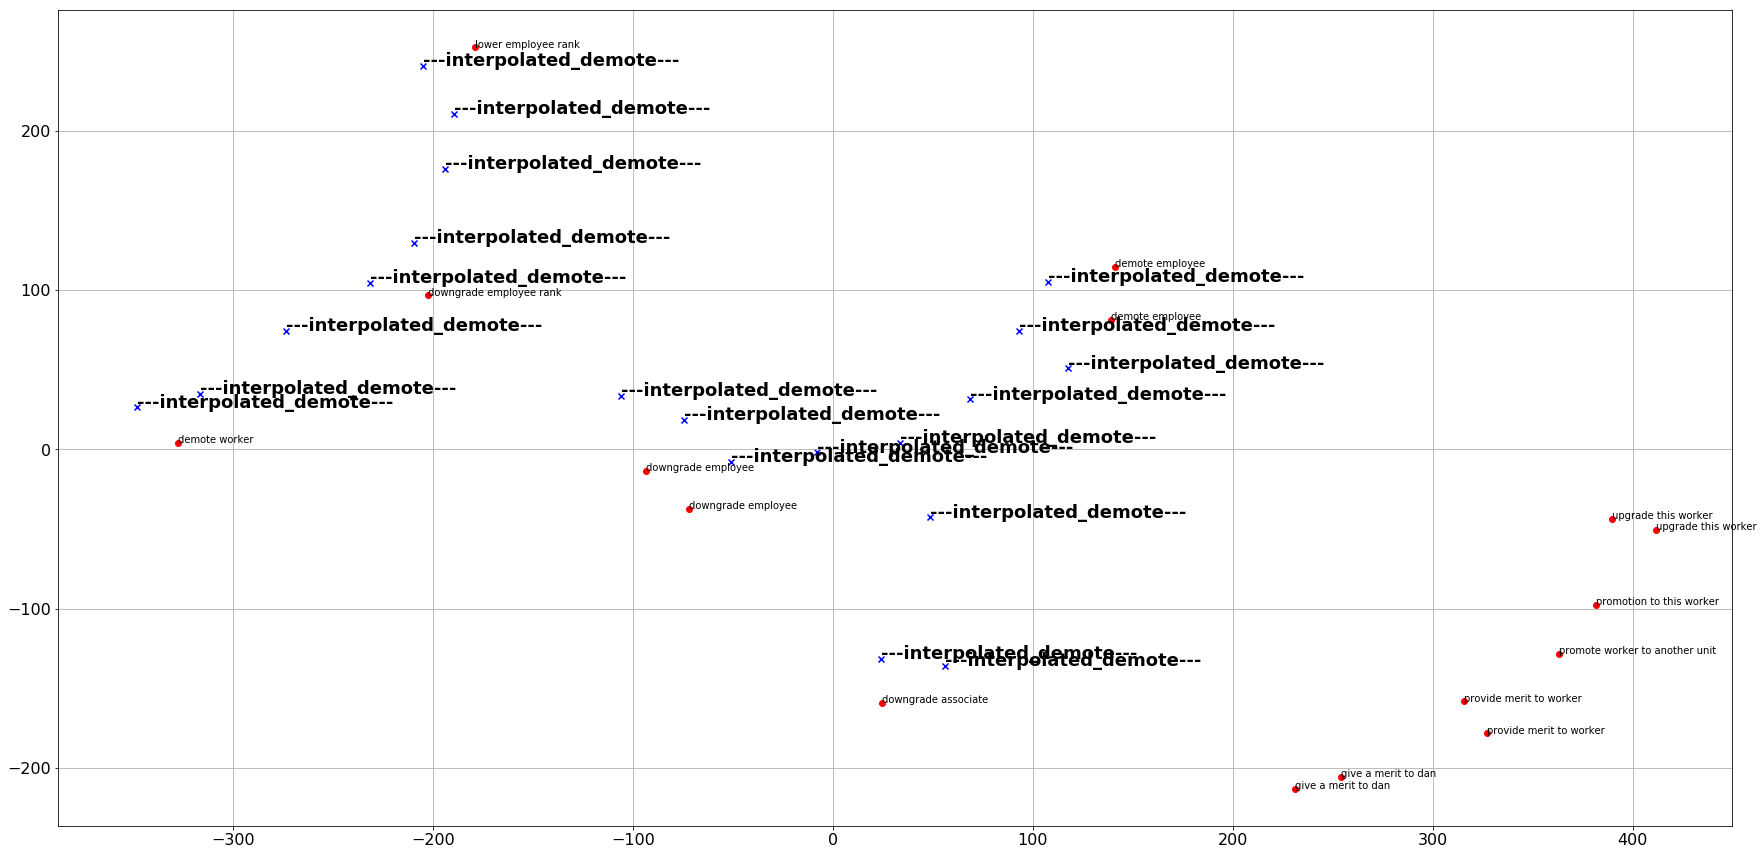

In [17]:
tsne=TSNE(n_components=2,perplexity = 5, method ='exact',verbose=1)
sentences_tsne = tsne.fit_transform(embeddings_np)
plt.subplots(figsize=(30, 15))
plt.grid()
## Grouping points by indexes
points = (sentences_tsne[:initial_sent_size,0], sentences_tsne[:initial_sent_size,1])
syntetic_points = (sentences_tsne[initial_sent_size:,0], sentences_tsne[initial_sent_size:,1])
## Ploting points
plt.scatter(points[0], points[1], c='r', marker='o')
plt.scatter(syntetic_points[0], syntetic_points[1], c='b', marker='x')

## Adding labels
for label, x, y in zip(sentences[0:initial_sent_size], points[0], points[1]):
    font = {'size' : 10, 'weight' : 'normal'}
    plt.rc('font', **font)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    
for label, x, y in zip(sentences[initial_sent_size:], syntetic_points[0], syntetic_points[1]):
    font = {'size' : 18, 'weight' : 'bold'}
    plt.rc('font', **font)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

## 2 - Gaussian Noise Interpolation

## 3 - _mixup_ Interpolation